<a href="https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/3.0.sign_detector_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Система распознавания дорожных знаков на датасете RTSD
## Обучение детектора

In [1]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone
if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'

import os
import json
#import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pycocotools.coco import COCO
import fiftyone as fo
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
#import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
import cv2

### Загрузчик данных

In [ ]:
# Преобразование классов знаков в 1 класс
def anno_to_bin_class(anno_file):
    '''Функция создает копию файла с аннотацией, преобразует все классы в 1 (знак)
    и сохраняет новый файл с аннотацией'''
    with open(os.path.join(dataset_path, anno_file), 'r') as read_file:
        anno_json = json.load(read_file)
    read_file.close()

    for i in range(len(anno_json['annotations'])):
        anno_json['annotations'][i]['category_id'] = 1    
    
    anno_json['categories'] = [{'id': 1, 'name': 'sign'}]
    
    anno_file_new = anno_file.split('.')[0] + '_bin_class.json'
    
    with open(os.path.join(dataset_path, anno_file_new), 'w') as f:
        json.dump(anno_json, f)#ensure_ascii=False, indent=4)
    f.close()

    return anno_json
anno_to_bin_class('train_anno.json')
anno_to_bin_class('train_anno_reduced.json')
anno_to_bin_class('val_anno.json')

In [3]:
class RTSD_dataset(Dataset):
  
    def __init__(self, json_path, img_path):
        self.json_path = json_path
        self.img_path = img_path
        
        with open(json_path, 'r') as read_file:
            self.anno = json.load(read_file)
        read_file.close()

        self.df_dataset = pd.DataFrame(self.anno.get('annotations'))
        self.df_images = pd.DataFrame(self.anno.get('images'))
        self.df_images.rename(columns={'id':'image_id'}, inplace=True)
        self.df_dataset = self.df_dataset.merge(self.df_images)
        self.df_dataset = self.df_dataset[['file_name', 'bbox', 'category_id']].groupby('file_name', as_index=False).agg(list)

    def __len__(self):
        return self.df_dataset.shape[0]
  
    def __getitem__(self, index):
        img_name = self.df_dataset.loc[index,'file_name']
        boxes = []
        for box in self.df_dataset.loc[index,'bbox']:
            box_for_rcnn = [box[0], box[1], box[0] + box[2], box[1] + box[3]]
            boxes.append(box_for_rcnn)
        boxes = torch.Tensor(boxes).to(torch.float)            # возможно нужно преобразовать x_max и y_max
        labels = torch.Tensor(self.df_dataset.loc[index, 'category_id']).to(torch.int64)
        #area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 0])
        #iscrowd = torch.zeros(labels.shape[0], dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        img = cv2.imread(os.path.join(self.img_path, img_name))/255.
        img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)
        return img, target

In [10]:
test = RTSD_dataset('data/train_anno_reduced.json', 'data/')
img, target = test.__getitem__(1)
target

{'boxes': tensor([[937., 210., 996., 282.],
         [937., 210., 996., 282.]]),
 'labels': tensor([11, 11])}

### Формирование батча

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

### Гиперпараметры

In [5]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
elif torch.backends.mps.is_available() == True:
    device = 'mps'
else:
    device = 'cpu'

backbone = 'resnet50'
#backbone = 'resnet50_v2'
#backbone = 'mobilenet_v3'
#backbone = 'mobilenet_v3_320'

# эпоха для загрузки параметров, обучение начинается со следующей
last_epoch = None      
n_epochs = 10       # полное количество эпох для обучения
batch_size = 8
num_classes = 2

device

### Инициализация модели, задание оптимизатора и функции потерь

In [41]:
def create_model(backbone, num_classes, pretrained=True):
    # load model pre-trained on COCO
    if backbone == 'resnet50':
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
    elif backbone == 'resnet50_v2':
        model =torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT')
    elif backbone == 'mobilenet_v3':
        model =torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights='FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT')
    elif backbone == 'mobilenet_v3_320':    
        model =torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights='FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT')
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [42]:
model = create_model(backbone=backbone, num_classes=2, pretrained=True).to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]

# optimizer
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)

# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Загрузка весов модели, состояния оптимизатора и шедулера
if last_epoch is not None:
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_detector_{backbone}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

train_dataset = RTSD_dataset(os.path.join(dataset_path, 'train_anno_bin_class.json'),
                                          dataset_path)
val_dataset = RTSD_dataset(os.path.join(dataset_path, 'val_anno_bin_class.json'), dataset_path)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)

### Трейн луп

In [37]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss

In [17]:
# Загрузка словарей с лоссами
if last_epoch is not None:
    train_losses = checkpoint['losses_train']
    val_losses = checkpoint['losses_val']
else:
    train_losses = []
    val_losses = []

try:
    for epoch in range(last_epoch + 1, n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                    'losses_train': train_losses,
                    'losses_val': val_losses
                    }, os.path.join(checkpoints_path, f'chkpt_detector_{backbone}_{epoch}.pth')
                   )
        torch.save(model, os.path.join(checkpoints_path, f'model_detector_{backbone}_{epoch}.pth'))
except KeyboardInterrupt:
    print('Прервано пользователем')

	Эпоха 0. Итерация 0/6774. Loss: 0.6479818820953369
	Эпоха 0. Итерация 50/6774. Loss: 0.2811393737792969
	Эпоха 0. Итерация 100/6774. Loss: 0.11667880415916443
	Эпоха 0. Итерация 150/6774. Loss: 0.08184801042079926
	Эпоха 0. Итерация 200/6774. Loss: 0.08028943091630936
	Эпоха 0. Итерация 250/6774. Loss: 0.10758046060800552
	Эпоха 0. Итерация 300/6774. Loss: 0.14786073565483093
	Эпоха 0. Итерация 350/6774. Loss: 0.09154942631721497
	Эпоха 0. Итерация 400/6774. Loss: 0.10243380814790726
	Эпоха 0. Итерация 450/6774. Loss: 0.12386808544397354
	Эпоха 0. Итерация 500/6774. Loss: 0.11992771178483963
	Эпоха 0. Итерация 550/6774. Loss: 0.11700306832790375
	Эпоха 0. Итерация 600/6774. Loss: 0.10319014638662338
	Эпоха 0. Итерация 650/6774. Loss: 0.08022608608007431
	Эпоха 0. Итерация 700/6774. Loss: 0.07238023728132248
	Эпоха 0. Итерация 750/6774. Loss: 0.09078812599182129
	Эпоха 0. Итерация 800/6774. Loss: 0.07555250823497772
	Эпоха 0. Итерация 850/6774. Loss: 0.07535095512866974
	Эпоха 0. Итера

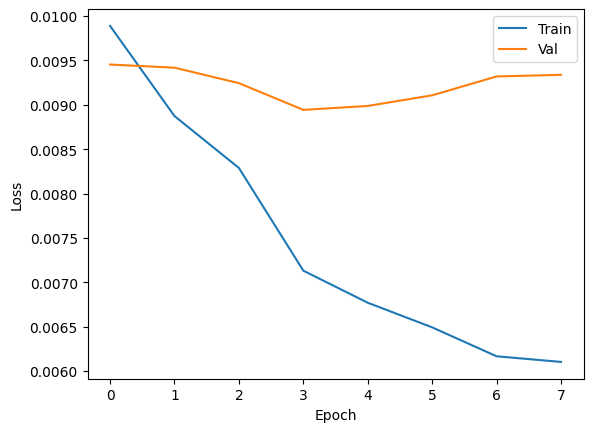

In [17]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
#ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()